# Table of Contents
[1. Objective](#scrollTo=kEAz1Gw3EoRx)

[2. Aggregation and Type Casting](#scrollTo=tzZFhqAsMLDb)

[3. Prep for PCA](#scrollTo=8YSCKAxwMn1G)

[4. PCA](#scrollTo=UVcA4S_JMsuJ)

[5. Creating Customer Groups for ARIMA](#scrollTo=lNefw8lZGGB0)

[6. Fitting ARIMA Models](#scrollTo=V9w3chZCGMZO)

# Objective

#### The objective of this notebook is to perform Principle Component Analysis to identify customer attributes that strongly contribute to their respective order amounts, in cases and gallons.  We then perform ARIMA forecasting on customer groups and Principle Components to observe seasonal ordering patterns and predictions for future orders placed by these customers.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
import gc
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import *
from statsmodels.tsa.arima.model import ARIMA

In [3]:
m = pd.read_csv("/content/drive/My Drive/merged_data.csv")

In [4]:
m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045540 entries, 0 to 1045539
Data columns (total 32 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   TRANSACTION_DATE           1045540 non-null  object 
 1   WEEK                       1045540 non-null  int64  
 2   YEAR                       1045540 non-null  int64  
 3   CUSTOMER_NUMBER            1045540 non-null  int64  
 4   ORDER_TYPE                 1034409 non-null  object 
 5   ORDERED_CASES              1045540 non-null  float64
 6   LOADED_CASES               1045540 non-null  float64
 7   DELIVERED_CASES            1045540 non-null  float64
 8   ORDERED_GALLONS            1045540 non-null  float64
 9   LOADED_GALLONS             1045540 non-null  float64
 10  DELIVERED_GALLONS          1045540 non-null  float64
 11  PRIMARY_GROUP_NUMBER       554645 non-null   float64
 12  FREQUENT_ORDER_TYPE        1045540 non-null  object 
 13  FIRST_DELIVE

# Aggregation and type casting

In [5]:
annual_orders = m.groupby(['YEAR', 'CUSTOMER_NUMBER'])['ORDERED_GALLONS'].sum().reset_index()

annual_orders['GT_400'] = annual_orders['ORDERED_GALLONS'] > 400

m = m.merge(annual_orders[['YEAR', 'CUSTOMER_NUMBER', 'ORDERED_GALLONS', 'GT_400']], on=['YEAR', 'CUSTOMER_NUMBER'], how='left')

unique_customers = m.drop_duplicates(subset=['YEAR', 'CUSTOMER_NUMBER'])

In [6]:
unique_customers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55653 entries, 0 to 1045526
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TRANSACTION_DATE           55653 non-null  object 
 1   WEEK                       55653 non-null  int64  
 2   YEAR                       55653 non-null  int64  
 3   CUSTOMER_NUMBER            55653 non-null  int64  
 4   ORDER_TYPE                 54373 non-null  object 
 5   ORDERED_CASES              55653 non-null  float64
 6   LOADED_CASES               55653 non-null  float64
 7   DELIVERED_CASES            55653 non-null  float64
 8   ORDERED_GALLONS_x          55653 non-null  float64
 9   LOADED_GALLONS             55653 non-null  float64
 10  DELIVERED_GALLONS          55653 non-null  float64
 11  PRIMARY_GROUP_NUMBER       23275 non-null  float64
 12  FREQUENT_ORDER_TYPE        55653 non-null  object 
 13  FIRST_DELIVERY_DATE        55653 non-null  object

In [7]:
cast = ['ORDER_TYPE', 'FREQUENT_ORDER_TYPE', 'COLD_DRINK_CHANNEL', 'TRADE_CHANNEL', 'SUB_TRADE_CHANNEL']
for column in cast:
    unique_customers[column] = unique_customers[column].astype('category')
unique_customers['Has Primary Group Number?'] = unique_customers['Has Primary Group Number?'].astype('boolean')

<ipython-input-7-237b3649509e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_customers[column] = unique_customers[column].astype('category')
<ipython-input-7-237b3649509e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_customers[column] = unique_customers[column].astype('category')
<ipython-input-7-237b3649509e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

# Prep for PCA

In [8]:
m2 = unique_customers.drop(['ORDERED_GALLONS_x', 'DELIVERED_GALLONS', 'TRANSACTION_DATE', 'WEEK', 'YEAR', 'CUSTOMER_NUMBER', 'LOADED_CASES', 'DELIVERED_CASES','LOADED_GALLONS', 'DELIVERED_CASES', 'PRIMARY_GROUP_NUMBER', 'FIRST_DELIVERY_DATE',
              'ON_BOARDING_DATE', 'ZIP_CODE', 'zip', 'full address', 'Month', 'ORDERED_CASES_RANGE', 'ORDERED_GALLONS_RANGE', 'Delivery_Rate_Cases', 'Delivery_Rate_Gallons', 'Case_delivery_costs',
               'Gallon_delivery_costs', 'Total_delivery_costs'], axis = 1)

In [9]:
m2['Has Primary Group Number?'] = m2['Has Primary Group Number?'].astype('bool')
m2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55653 entries, 0 to 1045526
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   ORDER_TYPE                 54373 non-null  category
 1   ORDERED_CASES              55653 non-null  float64 
 2   FREQUENT_ORDER_TYPE        55653 non-null  category
 3   COLD_DRINK_CHANNEL         55653 non-null  category
 4   TRADE_CHANNEL              55653 non-null  category
 5   SUB_TRADE_CHANNEL          55653 non-null  category
 6   LOCAL_MARKET_PARTNER       55653 non-null  bool    
 7   CO2_CUSTOMER               55653 non-null  bool    
 8   Has Primary Group Number?  55653 non-null  bool    
 9   ORDERED_GALLONS_y          55653 non-null  float64 
 10  GT_400                     55653 non-null  bool    
dtypes: bool(4), category(5), float64(2)
memory usage: 1.8 MB


# PCA

In [10]:
# Dummify factors
df_encoded = pd.get_dummies(m2[['ORDER_TYPE', 'FREQUENT_ORDER_TYPE', 'COLD_DRINK_CHANNEL', 'TRADE_CHANNEL', 'SUB_TRADE_CHANNEL']])

df_combined = pd.concat([m2.drop(columns=['ORDER_TYPE', 'FREQUENT_ORDER_TYPE', 'COLD_DRINK_CHANNEL', 'TRADE_CHANNEL', 'SUB_TRADE_CHANNEL']), df_encoded], axis=1)

In [11]:
target_variable = 'ORDERED_GALLONS_y'

# Drop highly correlated features
corr_matrix = df_combined.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df_reduced = df_combined.drop(columns=to_drop)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_reduced.drop(columns=[target_variable]))

pca = PCA(n_components=8)
data_pca = pca.fit_transform(data_scaled)

pca_columns = [f'PC{i+1}' for i in range(data_pca.shape[1])]
df_pca = pd.DataFrame(data_pca, columns=pca_columns)

df_pca[target_variable] = df_combined[target_variable].values

correlation_matrix = df_pca.corr()
print(correlation_matrix)

                            PC1           PC2           PC3           PC4  \
PC1                1.000000e+00 -4.573825e-16 -2.315842e-16 -1.836996e-16   
PC2               -4.573825e-16  1.000000e+00  2.773686e-16 -9.541055e-16   
PC3               -2.315842e-16  2.773686e-16  1.000000e+00  3.443279e-17   
PC4               -1.836996e-16 -9.541055e-16  3.443279e-17  1.000000e+00   
PC5                2.206142e-16  2.774997e-16 -6.160648e-16  3.289445e-16   
PC6               -2.338588e-16 -4.223422e-16 -5.874196e-16 -6.074517e-16   
PC7                1.023427e-16  3.236157e-16  4.414379e-16  4.241650e-16   
PC8                1.125072e-16 -3.366915e-16 -5.023885e-16 -1.381191e-17   
ORDERED_GALLONS_y -1.493876e-01  1.343048e-01 -9.922577e-02  9.681255e-02   

                            PC5           PC6           PC7           PC8  \
PC1                2.206142e-16 -2.338588e-16  1.023427e-16  1.125072e-16   
PC2                2.774997e-16 -4.223422e-16  3.236157e-16 -3.366915e-16  

#### Out of 8 principle components, components 1, 2, and 8 weak slight correlation with total gallons ordered per year.  Components 2 and 8 have positive correlation, and component 1 has negative correlation.

## Examining components

In [12]:
loadings = pca.components_

# Create a DataFrame for loadings
loading_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=df_reduced.drop(columns=[target_variable]).columns)

# Set a threshold for strong contributions
threshold = 0.3

# Filter the DataFrame to show only strong contributions
strong_contributions = loading_df[(loading_df.abs() >= threshold).any(axis=1)]

sorted_contributions = strong_contributions.abs().sort_values(by=strong_contributions.columns.tolist(), ascending=False)


print(sorted_contributions)

                                          PC1       PC2       PC3       PC4  \
COLD_DRINK_CHANNEL_GOODS             0.411731  0.190247  0.077946  0.046308   
COLD_DRINK_CHANNEL_DINING            0.385009  0.272364  0.090978  0.037790   
TRADE_CHANNEL_GENERAL RETAILER       0.384616  0.174105  0.141086  0.028897   
FREQUENT_ORDER_TYPE_SALES REP        0.097769  0.062570  0.314061  0.311853   
COLD_DRINK_CHANNEL_EVENT             0.029753  0.431417  0.165599  0.245046   
COLD_DRINK_CHANNEL_PUBLIC SECTOR     0.027926  0.124252  0.075321  0.095812   
TRADE_CHANNEL_RECREATION             0.027318  0.329046  0.133965  0.287951   
COLD_DRINK_CHANNEL_BULK TRADE        0.027301  0.127931  0.069700  0.385248   
COLD_DRINK_CHANNEL_WORKPLACE         0.027212  0.092836  0.442414  0.023184   
TRADE_CHANNEL_EDUCATION              0.024650  0.058678  0.085646  0.021253   
TRADE_CHANNEL_PROFESSIONAL SERVICES  0.015124  0.051788  0.318397  0.044677   
TRADE_CHANNEL_GENERAL                0.012814  0.131

In [13]:
resorted_contributions = strong_contributions.abs().sort_values(by=strong_contributions.columns.tolist(), ascending=True)
print(resorted_contributions)

                                          PC1       PC2       PC3       PC4  \
TRADE_CHANNEL_ACTIVITIES             0.002595  0.174596  0.120724  0.066983   
SUB_TRADE_CHANNEL_GAME CENTER        0.003576  0.164394  0.123101  0.049637   
TRADE_CHANNEL_GENERAL                0.012814  0.131317  0.084364  0.365080   
TRADE_CHANNEL_PROFESSIONAL SERVICES  0.015124  0.051788  0.318397  0.044677   
TRADE_CHANNEL_EDUCATION              0.024650  0.058678  0.085646  0.021253   
COLD_DRINK_CHANNEL_WORKPLACE         0.027212  0.092836  0.442414  0.023184   
COLD_DRINK_CHANNEL_BULK TRADE        0.027301  0.127931  0.069700  0.385248   
TRADE_CHANNEL_RECREATION             0.027318  0.329046  0.133965  0.287951   
COLD_DRINK_CHANNEL_PUBLIC SECTOR     0.027926  0.124252  0.075321  0.095812   
COLD_DRINK_CHANNEL_EVENT             0.029753  0.431417  0.165599  0.245046   
FREQUENT_ORDER_TYPE_SALES REP        0.097769  0.062570  0.314061  0.311853   
TRADE_CHANNEL_GENERAL RETAILER       0.384616  0.174

#### The strongest contributors to the most significant component are customers belonging to cold drink channels "dining", "goods", and the "general retailer" trade channel.

## Plotting components

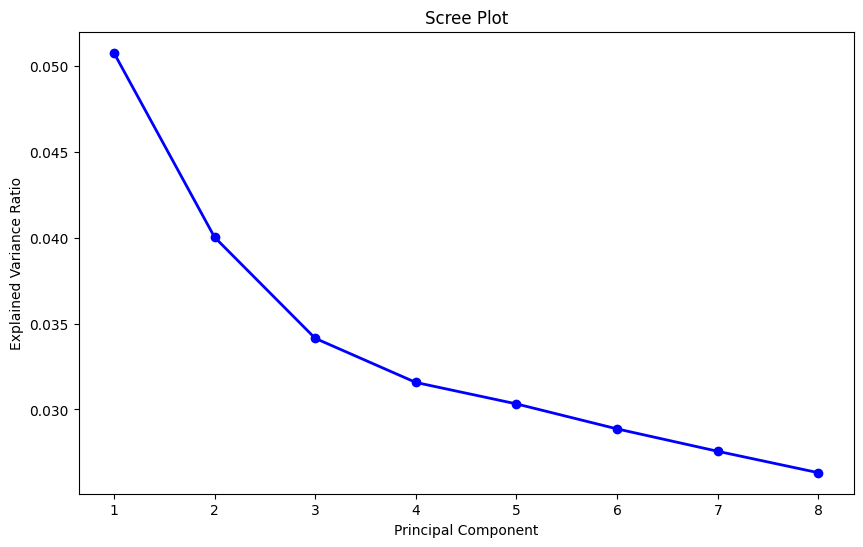

In [14]:
import matplotlib.pyplot as plt

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()


#### We can see that components 1, 2, and 3 capture a combined total of ~ 12.5% of the total variance, which is not a strong representation of the data.

# Creating customer groups for ARIMA

In [15]:
df_pca['Month'] = m['Month']
group_lt_400 = m[~m['GT_400']]
group_primary = m[m['PRIMARY_GROUP_NUMBER'].notnull()]
group_non_primary = m[m['PRIMARY_GROUP_NUMBER'].isnull()]
#group_local_partner = m[m['LOCAL_MARKET_PARTNER']]
#group_non_local_partner = m[~m['LOCAL_MARKET_PARTNER']]
#group_gt_400 = m[m['GT_400']]

monthly_pc1 = df_pca.groupby('Month')['PC1'].mean()
monthly_orders_lt_400 = group_lt_400.groupby('Month')['ORDERED_GALLONS_x'].mean()
monthly_orders_primary = group_primary.groupby('Month')['ORDERED_GALLONS_x'].mean()
monthly_orders_non_primary = group_non_primary.groupby('Month')['ORDERED_GALLONS_x'].mean()
#monthly_orders_gt_400 = group_gt_400.groupby('Month')['ORDERED_GALLONS_x'].mean()
#monthly_orders_local_partner = group_local_partner.groupby('Month')['ORDERED_GALLONS_x'].mean()
#monthly_orders_non_local_partner = group_non_local_partner.groupby('Month')['ORDERED_GALLONS_x'].mean()

# Fitting ARIMA models

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

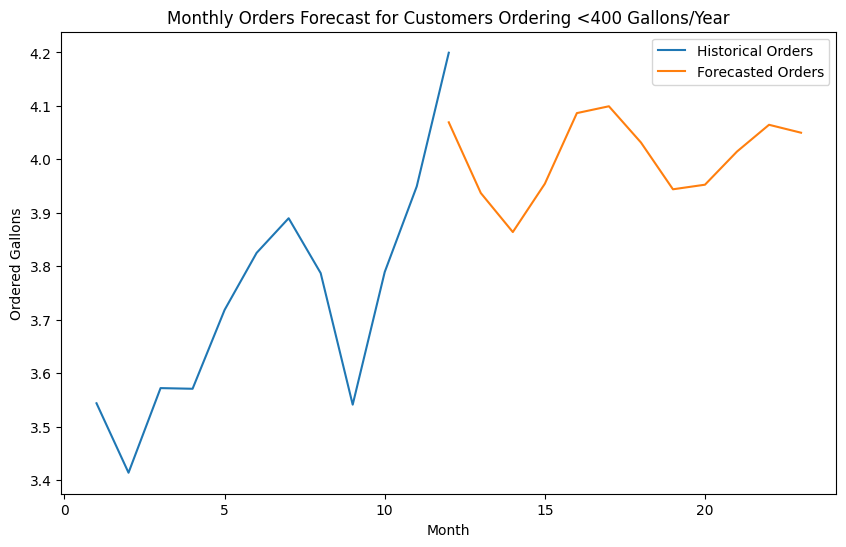

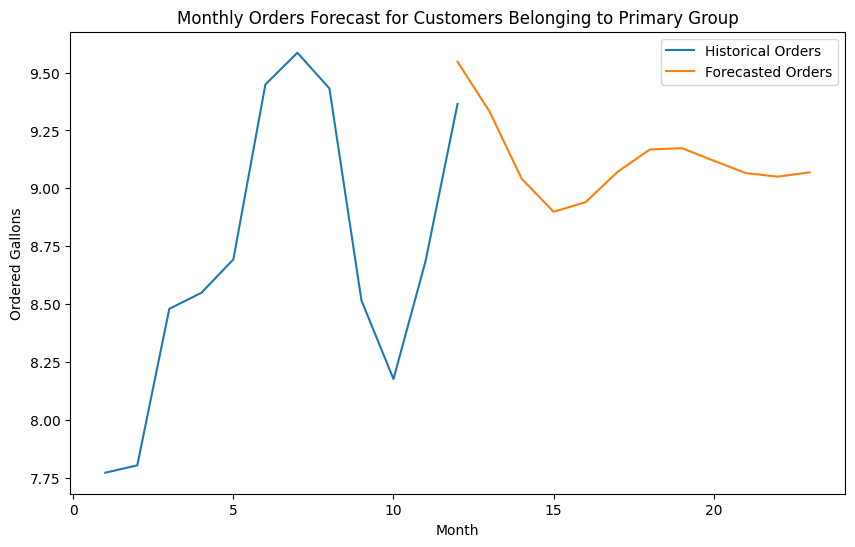

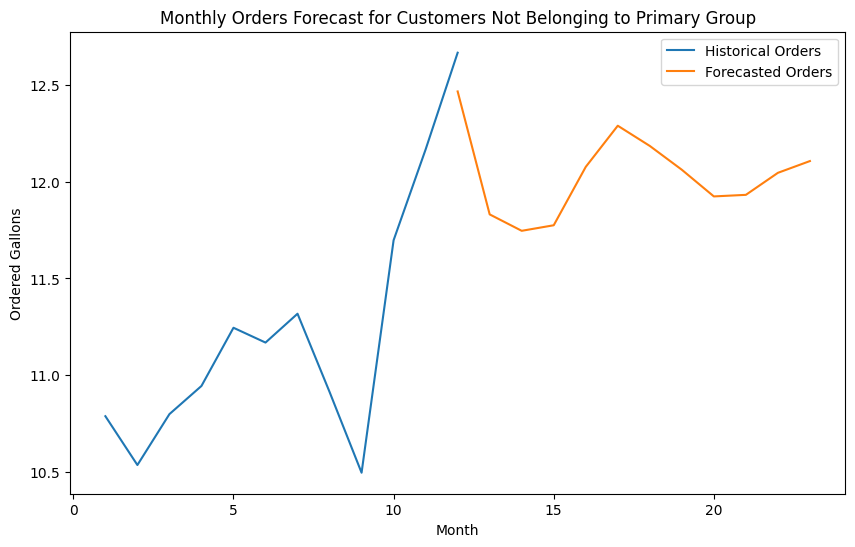

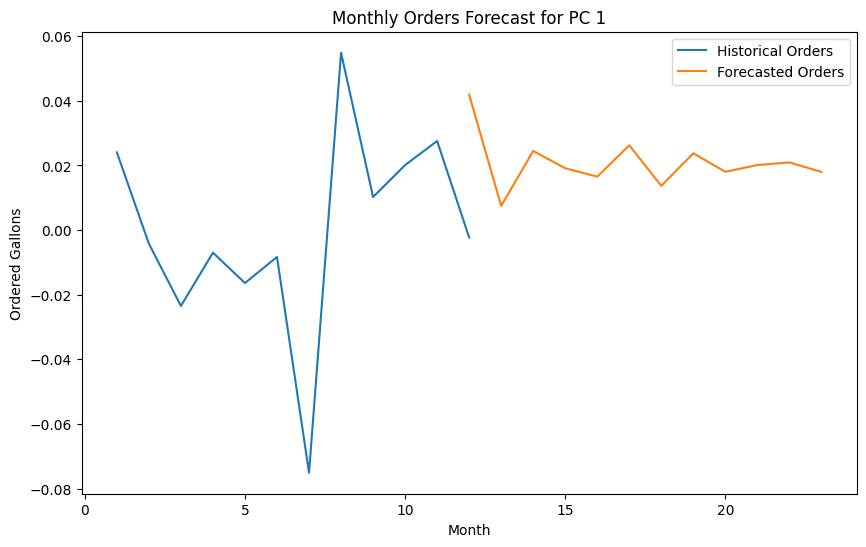


Forecasted Orders for Customers Ordering <400 Gallons/Year:
12    4.069306
13    3.937090
14    3.864147
15    3.954456
16    4.086531
17    4.099290
18    4.031619
19    3.944084
20    3.952658
21    4.014654
22    4.064685
23    4.049850
Name: predicted_mean, dtype: float64

Forecasted Orders for Customers Belonging to Primary Group:
12    9.546363
13    9.331719
14    9.041831
15    8.898633
16    8.940210
17    9.071386
18    9.167473
19    9.173516
20    9.119261
21    9.065858
22    9.050315
23    9.069040
Name: predicted_mean, dtype: float64

Forecasted Orders for Customers Not Belonging to Primary Group:
12    12.468397
13    11.831671
14    11.746637
15    11.775376
16    12.077762
17    12.290875
18    12.186203
19    12.062821
20    11.924769
21    11.932878
22    12.046932
23    12.107879
Name: predicted_mean, dtype: float64

Forecasted Orders for PC 1:
12    0.041916
13    0.007476
14    0.024489
15    0.019147
16    0.016536
17    0.026251
18    0.013697
19    0.023779
2

In [16]:
def fit_arima_and_forecast(time_series):
    model = ARIMA(time_series, order=(5,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=12)
    return forecast

#forecast_gt_400 = fit_arima_and_forecast(monthly_orders_gt_400)
forecast_lt_400 = fit_arima_and_forecast(monthly_orders_lt_400)
forecast_pc1 = fit_arima_and_forecast(monthly_pc1)
forecast_primary = fit_arima_and_forecast(monthly_orders_primary)
forecast_non_primary = fit_arima_and_forecast(monthly_orders_non_primary)
#forecast_local_partner = fit_arima_and_forecast(monthly_orders_local_partner)
#forecast_non_local_partner = fit_arima_and_forecast(monthly_orders_non_local_partner)

def plot_forecast(historical_data, forecast_data, title):
    plt.figure(figsize=(10,6))
    plt.plot(historical_data.index, historical_data.values, label='Historical Orders')
    plt.plot(range(len(historical_data), len(historical_data) + len(forecast_data)), forecast_data.values, label='Forecasted Orders')
    plt.xlabel('Month')
    plt.ylabel('Ordered Gallons')
    plt.title(title)
    plt.legend()
    plt.show()

#plot_forecast(monthly_orders_gt_400, forecast_gt_400, 'Monthly Orders Forecast for Customers Ordering >400 Gallons/Year')
plot_forecast(monthly_orders_lt_400, forecast_lt_400, 'Monthly Orders Forecast for Customers Ordering <400 Gallons/Year')
plot_forecast(monthly_orders_primary, forecast_primary, 'Monthly Orders Forecast for Customers Belonging to Primary Group')
plot_forecast(monthly_orders_non_primary, forecast_non_primary, 'Monthly Orders Forecast for Customers Not Belonging to Primary Group')
plot_forecast(monthly_pc1, forecast_pc1, 'Monthly Orders Forecast for PC 1')
#plot_forecast(monthly_orders_local_partner, forecast_local_partner, 'Monthly Orders Forecast for Local Market Partners')
#plot_forecast(monthly_orders_non_local_partner, forecast_non_local_partner, 'Monthly Orders Forecast for Non Local Market Partners')

#print("Forecasted Orders for Customers Ordering >400 Gallons/Year:")
#print(forecast_gt_400)
print("\nForecasted Orders for Customers Ordering <400 Gallons/Year:")
print(forecast_lt_400)
print("\nForecasted Orders for Customers Belonging to Primary Group:")
print(forecast_primary)
print("\nForecasted Orders for Customers Not Belonging to Primary Group:")
print(forecast_non_primary)
print("\nForecasted Orders for PC 1:")
print(forecast_pc1)
#print("\nForecasted Orders for Local Market Partners:")
#print(forecast_local_partner)
#print("\nForecasted Orders for Non Local Market Partners:")
#print(forecast_non_local_partner)

#### With these forecasts, we identify monthly ordering trends for customers who order less than 400 gallons per year and those who do/don't belong to primary groups.  Customers who are below the yearly order threshold are predicted to order between 3.9 and 4.1 gallons per month.  Customers belonging to primary groups tend to have lower monthly orders than those who are not in said groups, with forecasted values between 9 - 9.5 gallons per month and ~11.8 - 12.5 gallons per month respectively for each segment.  Principle component 1, the most representative component, shows a decline in historical demand for months 6 - 7, but has a relatively stable forecasted trend indicating a slight increase in future demand.